In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
pip install tensorflow matplotlib scikit-learn

  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/332.0 MB 3.1 MB/s eta 0:01:47
   ---------------------------------------- 1.0/332.0 MB 3.9 MB/s eta 0:01:26
   ---------------------------------------- 1.3/332.0 MB 1.8 MB/s eta 0:03:00
   ---------------------------------------- 1.6/332.0 MB 2.1 MB/s eta 0:02:37
   ---------------------------------------- 1.6/332.0 MB 2.1 MB/s eta 0:02:37
   ---------------------------------------- 2.1/332.0 MB 1.5 MB/s eta 0:03:37
   ---------------------------------------- 2.1/332.0 MB 1.5 MB/s eta 0:03:37
   ---------------------------------------- 2.1/332.0 MB 1.5 MB/s eta 0:03:37
   ---------------------------------------- 2.1/332.0 MB 1.5 MB/s eta 0:03:37
   ---------------------------------------- 2.1/332.0 MB 1.5 MB/s eta 0:03:37
   ---------------------------------------- 2.4/332.0 MB 942.1 kB/s eta 0:05:50
   ---


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 14s 1us/step


In [6]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train_flat = x_train.reshape((-1, 28*28))
x_test_flat = x_test.reshape((-1, 28*28))
num_classes = 10
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

In [7]:
x_train_flat, x_val_flat, y_train_cat, y_val_cat, y_train, y_val = train_test_split(
    x_train_flat, y_train_cat, y_train, test_size=0.12, random_state=42, stratify=y_train
)

In [11]:
def build_mlp(input_dim=784, hidden_layers=[512, 256], dropout_rate=0.3, l2_reg=1e-4):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for units in hidden_layers:
        model.add(layers.Dense(units, activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [12]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
chkpt_path = "mlp_mnist_best.h5"
mc = callbacks.ModelCheckpoint(chkpt_path, monitor='val_loss', save_best_only=True)

In [16]:
model = build_mlp(hidden_layers=[512, 256], dropout_rate=0.3, l2_reg=1e-4)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
history = model.fit(x_train_flat, y_train_cat,
                    validation_data=(x_val_flat, y_val_cat),
                    epochs=20,
                    batch_size=128,
                    callbacks=[es, mc],
                    verbose=2)

Epoch 1/20


413/413 - 11s - 28ms/step - accuracy: 0.9077 - loss: 0.3873 - val_accuracy: 0.9564 - val_loss: 0.2195
Epoch 2/20


413/413 - 9s - 21ms/step - accuracy: 0.9604 - loss: 0.2091 - val_accuracy: 0.9658 - val_loss: 0.1884
Epoch 3/20


413/413 - 10s - 24ms/step - accuracy: 0.9695 - loss: 0.1764 - val_accuracy: 0.9710 - val_loss: 0.1698
Epoch 4/20


413/413 - 10s - 24ms/step - accuracy: 0.9750 - loss: 0.1570 - val_accuracy: 0.9736 - val_loss: 0.1619
Epoch 5/20


413/413 - 10s - 25ms/step - accuracy: 0.9779 - loss: 0.1448 - val_accuracy: 0.9774 - val_loss: 0.1495
Epoch 6/20
413/413 - 10s - 25ms/step - accuracy: 0.9797 - loss: 0.1371 - val_accuracy: 0.9771 - val_loss: 0.1503
Epoch 7/20
413/413 - 8s - 20ms/step - accuracy: 0.9811 - loss: 0.1310 - val_accuracy: 0.9754 - val_loss: 0.1567
Epoch 8/20


413/413 - 10s - 25ms/step - accuracy: 0.9812 - loss: 0.1291 - val_accuracy: 0.9779 - val_loss: 0.1445
Epoch 9/20
413/413 - 10s - 25ms/step - accuracy: 0.9828 - loss: 0.1229 - val_accuracy: 0.9772 - val_loss: 0.1532
Epoch 10/20
413/413 - 10s - 24ms/step - accuracy: 0.9828 - loss: 0.1245 - val_accuracy: 0.9783 - val_loss: 0.1486
Epoch 11/20
413/413 - 10s - 25ms/step - accuracy: 0.9844 - loss: 0.1189 - val_accuracy: 0.9764 - val_loss: 0.1522
Epoch 12/20
413/413 - 9s - 23ms/step - accuracy: 0.9845 - loss: 0.1183 - val_accuracy: 0.9782 - val_loss: 0.1475


In [18]:
model.save("mlp_mnist_model.h5")

In [19]:
test_loss, test_acc = model.evaluate(x_test_flat, y_test_cat, verbose=0)
print(f"Test loss: {test_loss:.4f}  Test accuracy: {test_acc:.4f}")

y_pred_probs = model.predict(x_test_flat)
y_pred = np.argmax(y_pred_probs, axis=1)


Test loss: 0.1408  Test accuracy: 0.9781
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [20]:
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))


Classification report:
              precision    recall  f1-score   support

           0     0.9758    0.9878    0.9817       980
           1     0.9843    0.9938    0.9890      1135
           2     0.9794    0.9661    0.9727      1032
           3     0.9754    0.9832    0.9793      1010
           4     0.9856    0.9756    0.9806       982
           5     0.9712    0.9843    0.9777       892
           6     0.9732    0.9864    0.9798       958
           7     0.9891    0.9669    0.9779      1028
           8     0.9790    0.9579    0.9683       974
           9     0.9667    0.9782    0.9724      1009

    accuracy                         0.9781     10000
   macro avg     0.9780    0.9780    0.9779     10000
weighted avg     0.9782    0.9781    0.9781     10000



In [21]:
cm = confusion_matrix(y_test, y_pred)

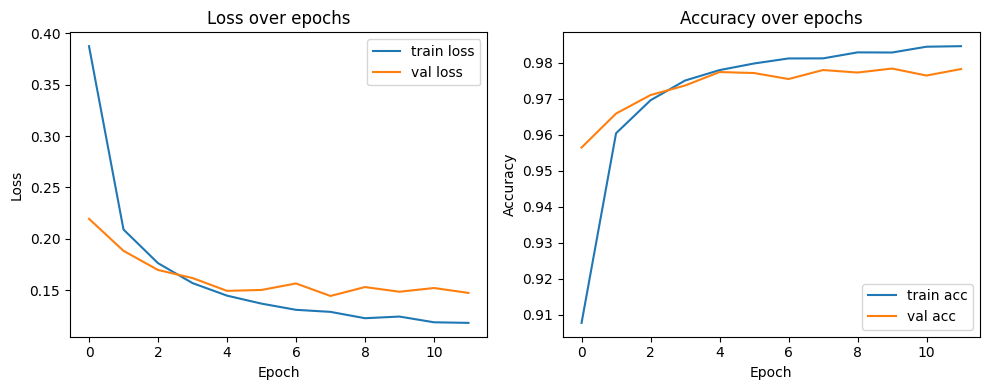

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.tight_layout()
plt.show()

In [ ]:
mis_idx = np.where(y_pred != y_test)[0]
corr_idx = np.where(y_pred == y_test)[0]

def plot_examples(indices, title, n=9):
    plt.figure(figsize=(7,7))
    chosen = np.random.choice(indices, size=min(n, len(indices)), replace=False)
    for i, idx in enumerate(chosen):
        plt.subplot(3,3,i+1)
        plt.imshow(x_test[idx], cmap='gray')
        plt.axis('off')
        plt.title(f"T:{y_test[idx]} P:{y_pred[idx]}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

if len(mis_idx) > 0:
    plot_examples(mis_idx, "Misclassified examples (True: T, Predicted: P)", n=9)
plot_examples(corr_idx, "Correctly classified examples (True: T, Predicted: P)", n=9)

print("Saved: mlp_mnist_model.h5 and mlp_mnist_best.h5")